In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV
from scipy import stats

from sklearn.metrics import confusion_matrix
import time

In [1]:
(20000-2000)/6000

3.0

In [3]:
srate = 2000
new_srate = 200
sec = 1 # time step length
ele = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)
# 去除第一秒的数据,且重采样到200hz
ele = np.reshape(
    ele, (20000,15,4,2,14), order = 'F').transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]

# 分成头部与耳部，标注label
ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8)
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6)
# labels = np.repeat([0,1,2,3], ear_ele.shape[0]//4)

In [4]:
ear_ele.shape

(1080, 200, 8)

In [5]:
# np.roll(np.arange(24).reshape(3,8), 1)
def roll_window(x, y, stride = 100):
    '''
    args:
        x(sample, channel, time_step): numpy ndarray, must contain the axis which want to be rolled
        axis: int, the specific axis
        stride: int, step length
    '''
    x_temp = x.reshape(x.shape[0], x.shape[1],-1,stride)  # 改AXIS必须改这里
    strided_x = np.asarray([np.roll(x_temp, shift = i, axis = 2).reshape(x.shape[0], x.shape[1], -1)\
                            for i in np.arange(x_temp.shape[2])])
    y = np.tile(y, x_temp.shape[2])
    return strided_x.reshape(-1, x.shape[1], x.shape[2]), y

In [5]:
# batches, channels, time step
ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6).transpose([0,2,1])

# z-score
head_ele = (head_ele - head_ele.mean(axis = 2)[...,np.newaxis])\
                /head_ele.std(axis = 2)[...,np.newaxis]

ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                /ear_ele.std(axis = 2)[...,np.newaxis]

y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))

################################ TFA #########################
print('begin to TFA')
mask = np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))-2
# time frequency analysis for ear-EEG
temp_ear_ele = []
for i in ear_ele:
    _,_,temp = time_frequency_analysis(
        i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 1)
    # _,_,temp = time_frequency_analysis_output_1s(
    #     i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 1)    
    temp_ear_ele.append(temp)
    
# if use mask
ear_ele = np.asarray(temp_ear_ele)[:,mask,:]

# # if do not use mask
# ear_ele = np.asarray(temp_ear_ele)
del temp_ear_ele
##############################################################


ear_X_train, ear_X_test, ear_y_train, ear_y_test = train_test_split(ear_ele, y, test_size=0.1)
# head_X_train, head_X_test, head_y_train, head_y_test = train_test_split(head_ele, y, test_size=0.1)
# ################# DATA generate ##############################
# ear_X_train, ear_y_train = roll_window(ear_X_train, ear_y_train)
# ear_X_train, ear_y_train = shuffle(ear_X_train, ear_y_train)
##############################################################
ear_ele, ear_y, ear_splits = ts.combine_split_data([ear_X_train, ear_X_test], [ear_y_train, ear_y_test])

begin to TFA


In [6]:
ear_X_train.shape

(972, 27, 200)

In [ ]:
# batch_tfms = [ts.TSStandardize(by_sample=True)]
# tfms  = [None, [ts.Categorize()]]
# dls = ts.get_ts_dls(ear_ele, ear_y, 
#                  splits=ear_splits, 
#                  tfms=tfms, drop_last=False, 
#                  shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)

# model = ts.build_ts_model(ts.ROCKET, dls=dls)

# X_train, y_train = ts.create_rocket_features(dls.train, model)
# X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
# X_train.shape, X_valid.shape

In [2]:
def cross_validation(x1, x2, y, cv_number = 20, test_size = 0.1):
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]
    cfm = np.zeros([4,4])
    for _ in np.arange(cv_number):
        x1, x2, y = shuffle(x1, x2, y)
        splits = ts.get_splits(y, valid_size= test_size, stratify=True, shuffle=True)
            

        dls_x1 = ts.get_ts_dls(x1, y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        dls_x2 = ts.get_ts_dls(x2, y, 
                 splits=splits, 
                 tfms=tfms, drop_last=False, 
                 shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        for dls in [dls_x1, dls_x2]:
            model = ts.build_ts_model(ts.ROCKET, dls=dls)

            X_train, y_train = ts.create_rocket_features(dls.train, model)
            X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
            X_train.shape, X_valid.shape

            ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
            ridge.fit(X_train, y_train)
            print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
            acc.append(ridge.score(X_valid, y_valid))

            cfm += confusion_matrix(y_valid, ridge.predict(X_valid))
            print(cfm)
    return acc, cfm

In [13]:
# np.asarray(acc_total).mean(axis = 1)

array([0.7       , 0.76041667, 0.68958333, 0.68958333, 0.70833333,
       0.71666667, 0.68333333, 0.69166667, 0.67916667, 0.67916667])

In [12]:
np.asarray(acc_total).mean(axis = 1)
np.asarray(acc_total_2).mean(axis = 1)

array([0.4625    , 0.45694444, 0.45833333, 0.45648148, 0.45601852,
       0.48981481, 0.45046296, 0.45601852, 0.4462963 , 0.4837963 ])

In [11]:

# pd.DataFrame({'number': np.arange(1,21)}).to_csv('result\ROCKET_ACC_01_13.csv', index = 0)


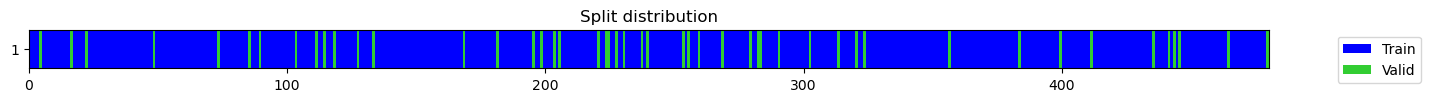

alpha: 1.00E+01  train: 0.99537  valid: 0.50000
[[3. 1. 1. 7.]
 [3. 7. 2. 0.]
 [4. 1. 7. 0.]
 [2. 2. 1. 7.]]
alpha: 1.00E+02  train: 0.78241  valid: 0.47917
[[ 8.  3.  1. 12.]
 [ 8. 11.  5.  0.]
 [ 8.  2. 14.  0.]
 [ 4.  3.  3. 14.]]


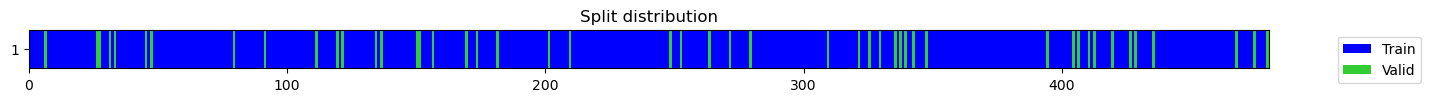

alpha: 1.00E+01  train: 0.99537  valid: 0.68750
[[18.  3.  3. 12.]
 [11. 18.  5.  2.]
 [ 9.  2. 24.  1.]
 [ 7.  5.  4. 20.]]
alpha: 1.00E+01  train: 0.99537  valid: 0.70833
[[27.  4.  4. 13.]
 [13. 26.  6.  3.]
 [ 9.  2. 35.  2.]
 [ 8.  7.  7. 26.]]


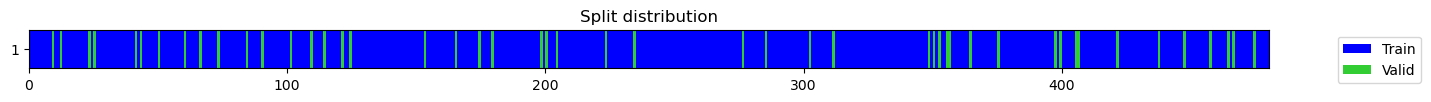

alpha: 1.00E+01  train: 0.99537  valid: 0.58333
[[32.  6.  8. 14.]
 [15. 34.  8.  3.]
 [10.  2. 44.  4.]
 [11.  7. 10. 32.]]
alpha: 1.00E+01  train: 0.98843  valid: 0.54167
[[37.  8. 12. 15.]
 [16. 42. 10.  4.]
 [13.  2. 51.  6.]
 [13.  8. 13. 38.]]


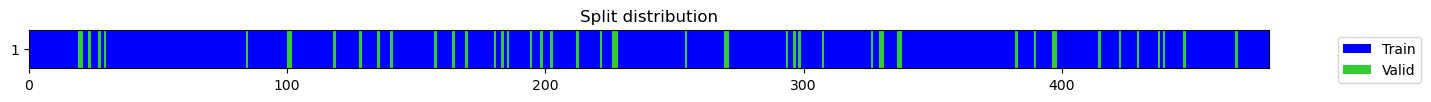

alpha: 1.00E+01  train: 0.99537  valid: 0.58333
[[44.  9. 14. 17.]
 [16. 50. 13.  5.]
 [14.  7. 57.  6.]
 [15.  8. 16. 45.]]
alpha: 1.00E+02  train: 0.77778  valid: 0.66667
[[53.  9. 15. 19.]
 [17. 57. 15.  7.]
 [15. 10. 65.  6.]
 [17.  9. 17. 53.]]


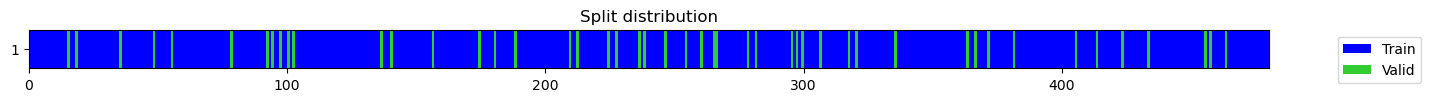

alpha: 1.00E+01  train: 0.99306  valid: 0.54167
[[58.  9. 19. 22.]
 [20. 63. 16.  9.]
 [16. 11. 72.  9.]
 [20. 10. 17. 61.]]
alpha: 1.00E+02  train: 0.77315  valid: 0.68750
[[68.  9. 19. 24.]
 [21. 72. 17. 10.]
 [18. 13. 78. 11.]
 [23. 11. 17. 69.]]


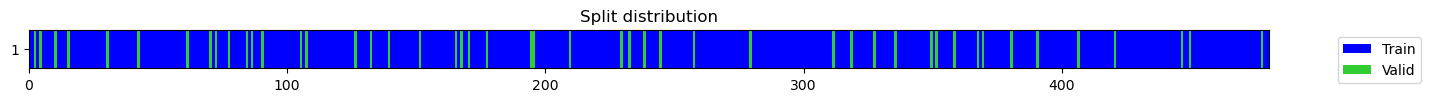

alpha: 1.00E+01  train: 0.99306  valid: 0.47917
[[74. 11. 23. 24.]
 [22. 80. 20. 10.]
 [23. 15. 81. 13.]
 [24. 15. 18. 75.]]
alpha: 1.00E+01  train: 0.99769  valid: 0.68750
[[81. 12. 26. 25.]
 [23. 90. 20. 11.]
 [24. 15. 90. 15.]
 [27. 16. 19. 82.]]


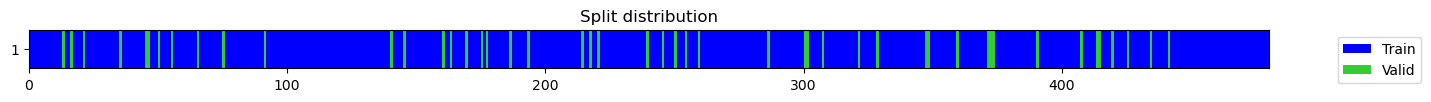

alpha: 1.00E+01  train: 0.99306  valid: 0.70833
[[92. 12. 27. 25.]
 [25. 98. 22. 11.]
 [27. 16. 97. 16.]
 [29. 16. 21. 90.]]
alpha: 1.00E+02  train: 0.77778  valid: 0.66667
[[102.  12.  28.  26.]
 [ 27. 106.  23.  12.]
 [ 29.  17. 105.  17.]
 [ 31.  17.  24.  96.]]


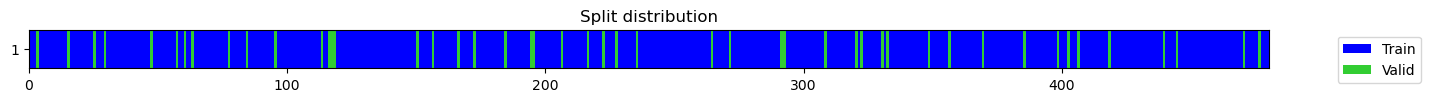

alpha: 1.00E+01  train: 0.99537  valid: 0.62500
[[111.  13.  29.  27.]
 [ 28. 115.  23.  14.]
 [ 32.  20. 110.  18.]
 [ 35.  17.  25. 103.]]
alpha: 1.00E+01  train: 0.99306  valid: 0.60417
[[118.  14.  30.  30.]
 [ 30. 125.  23.  14.]
 [ 33.  23. 116.  20.]
 [ 39.  17.  27. 109.]]


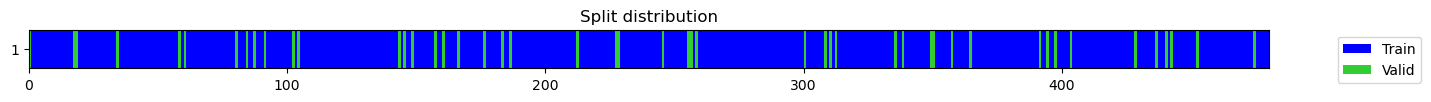

alpha: 1.00E+01  train: 0.99537  valid: 0.62500
[[126.  17.  30.  31.]
 [ 30. 134.  26.  14.]
 [ 36.  24. 124.  20.]
 [ 42.  18.  30. 114.]]
alpha: 1.00E+01  train: 0.99306  valid: 0.60417
[[133.  20.  30.  33.]
 [ 31. 142.  28.  15.]
 [ 38.  26. 132.  20.]
 [ 44.  19.  33. 120.]]


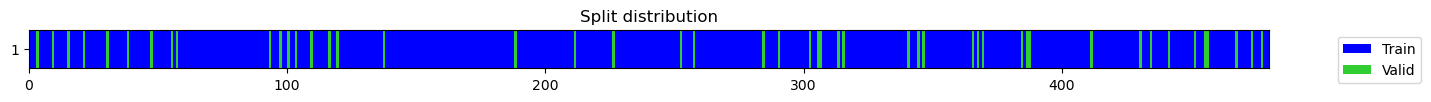

alpha: 1.00E+01  train: 0.99537  valid: 0.50000
[[136.  21.  36.  35.]
 [ 32. 149.  30.  17.]
 [ 39.  29. 140.  20.]
 [ 44.  23.  35. 126.]]
alpha: 1.00E+02  train: 0.77315  valid: 0.62500
[[142.  22.  40.  36.]
 [ 33. 159.  31.  17.]
 [ 43.  30. 147.  20.]
 [ 45.  25.  37. 133.]]


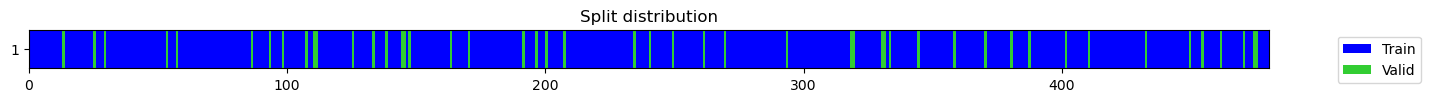

alpha: 1.00E+01  train: 0.99769  valid: 0.66667
[[150.  22.  44.  36.]
 [ 33. 168.  34.  17.]
 [ 45.  31. 154.  22.]
 [ 46.  26.  39. 141.]]
alpha: 1.00E+02  train: 0.77546  valid: 0.60417
[[157.  22.  47.  38.]
 [ 33. 177.  36.  18.]
 [ 49.  33. 159.  23.]
 [ 48.  27.  40. 149.]]


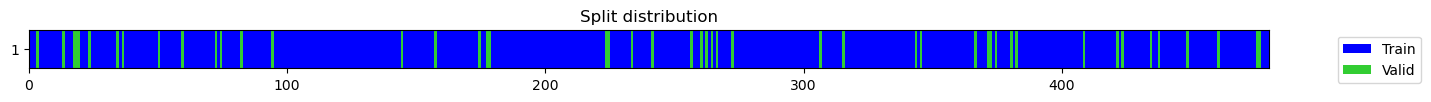

alpha: 1.00E+01  train: 0.99306  valid: 0.56250
[[161.  25.  52.  38.]
 [ 36. 185.  37.  18.]
 [ 51.  34. 165.  26.]
 [ 50.  28.  40. 158.]]
alpha: 1.00E+02  train: 0.76852  valid: 0.64583
[[169.  27.  53.  39.]
 [ 39. 193.  38.  18.]
 [ 53.  36. 172.  27.]
 [ 53.  29.  40. 166.]]


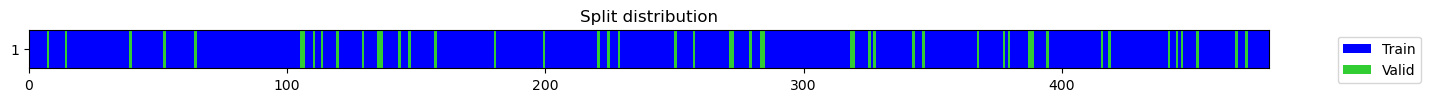

alpha: 1.00E+01  train: 0.99306  valid: 0.66667
[[176.  28.  55.  41.]
 [ 40. 203.  39.  18.]
 [ 56.  37. 178.  29.]
 [ 54.  29.  42. 175.]]
alpha: 1.00E+02  train: 0.75463  valid: 0.70833
[[183.  28.  58.  43.]
 [ 40. 213.  41.  18.]
 [ 57.  40. 183.  32.]
 [ 54.  29.  42. 187.]]


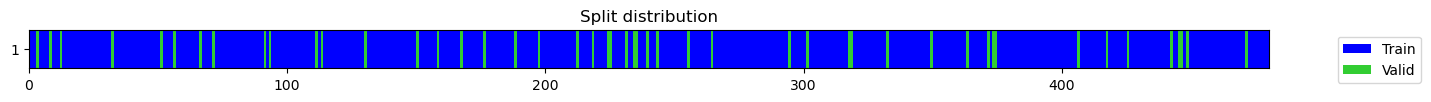

alpha: 1.00E+01  train: 0.99769  valid: 0.58333
[[185.  30.  61.  48.]
 [ 41. 224.  41.  18.]
 [ 57.  41. 193.  33.]
 [ 55.  33.  44. 192.]]
alpha: 1.00E+02  train: 0.78009  valid: 0.66667
[[188.  32.  63.  53.]
 [ 41. 235.  42.  18.]
 [ 58.  41. 203.  34.]
 [ 56.  34.  46. 200.]]


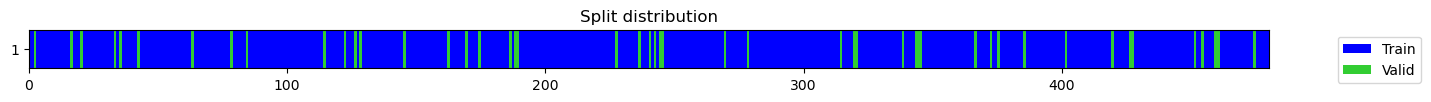

alpha: 1.00E+01  train: 0.99306  valid: 0.62500
[[196.  32.  64.  56.]
 [ 45. 242.  42.  19.]
 [ 59.  41. 211.  37.]
 [ 57.  36.  48. 207.]]
alpha: 1.00E+02  train: 0.77083  valid: 0.66667
[[204.  32.  65.  59.]
 [ 48. 249.  43.  20.]
 [ 61.  41. 220.  38.]
 [ 59.  37.  49. 215.]]


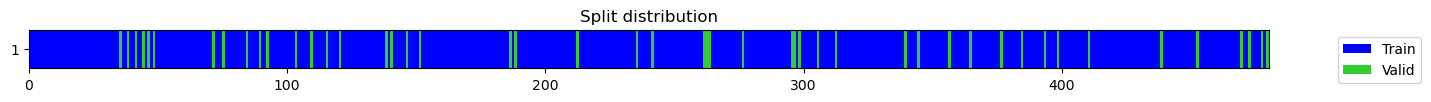

alpha: 1.00E+01  train: 0.99537  valid: 0.50000
[[211.  33.  68.  60.]
 [ 49. 254.  45.  24.]
 [ 65.  42. 226.  39.]
 [ 62.  40.  49. 221.]]
alpha: 1.00E+01  train: 0.99074  valid: 0.60417
[[218.  34.  70.  62.]
 [ 50. 260.  48.  26.]
 [ 68.  42. 234.  40.]
 [ 66.  40.  49. 229.]]


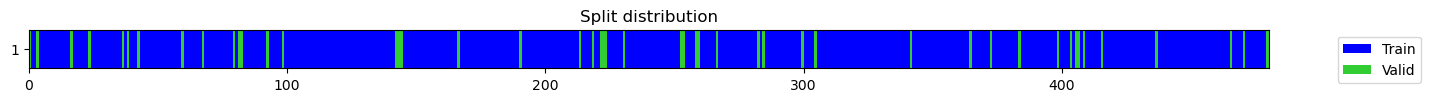

alpha: 1.00E+01  train: 0.99769  valid: 0.58333
[[223.  35.  73.  65.]
 [ 53. 266.  48.  29.]
 [ 71.  43. 242.  40.]
 [ 66.  41.  51. 238.]]
alpha: 1.00E+01  train: 0.99074  valid: 0.62500
[[231.  35.  75.  67.]
 [ 57. 272.  49.  30.]
 [ 73.  44. 251.  40.]
 [ 67.  42.  54. 245.]]


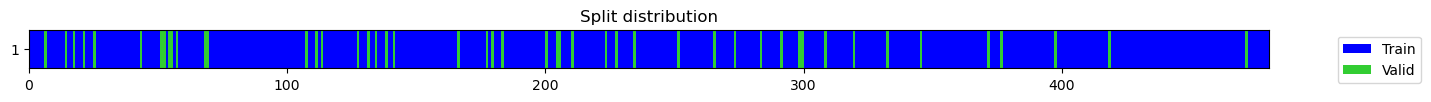

alpha: 1.00E+01  train: 0.99537  valid: 0.45833
[[236.  36.  76.  72.]
 [ 59. 278.  51.  32.]
 [ 80.  45. 255.  40.]
 [ 69.  43.  56. 252.]]
alpha: 1.00E+02  train: 0.80093  valid: 0.58333
[[243.  39.  76.  74.]
 [ 60. 288.  52.  32.]
 [ 85.  46. 261.  40.]
 [ 73.  44.  58. 257.]]


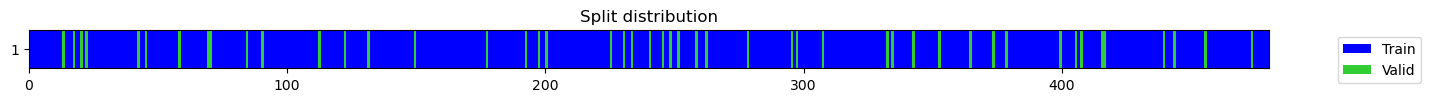

alpha: 1.00E+01  train: 0.99537  valid: 0.62500
[[252.  39.  77.  76.]
 [ 62. 295.  53.  34.]
 [ 87.  51. 266.  40.]
 [ 73.  44.  61. 266.]]
alpha: 1.00E+02  train: 0.77778  valid: 0.60417
[[260.  41.  78.  77.]
 [ 65. 302.  54.  35.]
 [ 88.  56. 271.  41.]
 [ 73.  44.  64. 275.]]


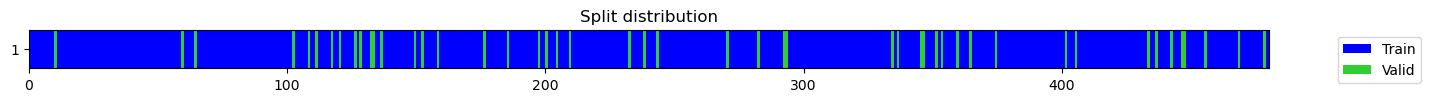

alpha: 1.00E+01  train: 0.99537  valid: 0.72917
[[270.  41.  80.  77.]
 [ 66. 311.  56.  35.]
 [ 91.  56. 279.  42.]
 [ 75.  45.  65. 283.]]
alpha: 1.00E+02  train: 0.76389  valid: 0.68750
[[279.  42.  82.  77.]
 [ 68. 320.  57.  35.]
 [ 94.  57. 285.  44.]
 [ 77.  45.  66. 292.]]


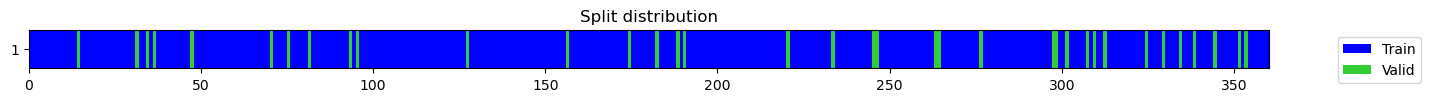

alpha: 1.00E+01  train: 1.00000  valid: 0.61111
[[4. 1. 1. 3.]
 [3. 5. 0. 1.]
 [2. 2. 5. 0.]
 [1. 0. 0. 8.]]
alpha: 1.00E+02  train: 0.87037  valid: 0.61111
[[ 6.  2.  5.  5.]
 [ 4. 11.  1.  2.]
 [ 4.  3. 11.  0.]
 [ 2.  0.  0. 16.]]


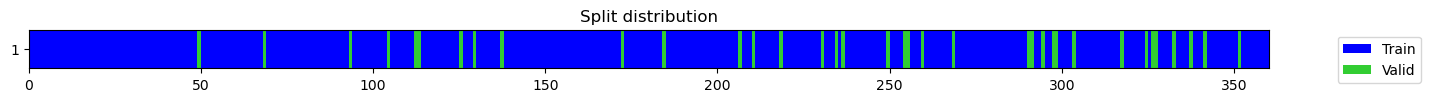

alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[12.  2.  7.  6.]
 [ 6. 17.  1.  3.]
 [ 5.  4. 16.  2.]
 [ 3.  0.  0. 24.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[17.  3.  9.  7.]
 [ 8. 22.  3.  3.]
 [ 6.  4. 23.  3.]
 [ 4.  0.  0. 32.]]


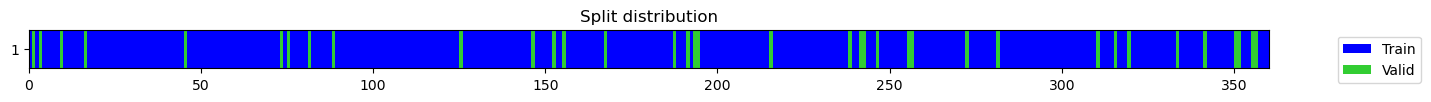

alpha: 1.00E+01  train: 1.00000  valid: 0.66667
[[19.  5. 13.  8.]
 [ 9. 29.  3.  4.]
 [ 6.  4. 31.  4.]
 [ 5.  1.  0. 39.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[22.  6. 16. 10.]
 [ 9. 37.  3.  5.]
 [ 6.  4. 39.  5.]
 [ 7.  2.  0. 45.]]


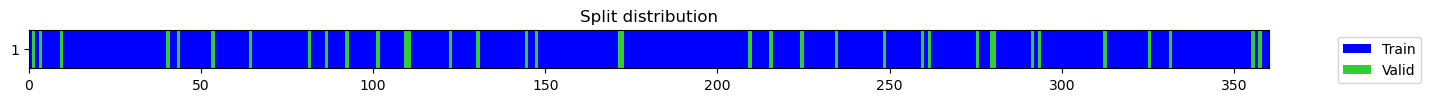

alpha: 1.00E+01  train: 0.99691  valid: 0.72222
[[28.  7. 17. 11.]
 [10. 43.  5.  5.]
 [ 6.  6. 46.  5.]
 [ 8.  3.  0. 52.]]
alpha: 1.00E+02  train: 0.87346  valid: 0.86111
[[35.  7. 19. 11.]
 [12. 49.  6.  5.]
 [ 6.  6. 55.  5.]
 [ 8.  3.  0. 61.]]


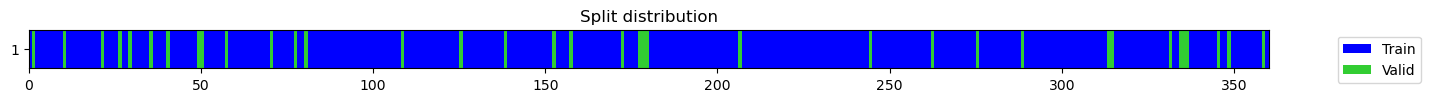

alpha: 1.00E+01  train: 0.99691  valid: 0.83333
[[42.  7. 20. 12.]
 [14. 56.  6.  5.]
 [ 6.  6. 64.  5.]
 [ 9.  4.  0. 68.]]
alpha: 1.00E+02  train: 0.86728  valid: 0.75000
[[47.  7. 22. 14.]
 [15. 64.  6.  5.]
 [ 6.  6. 73.  5.]
 [11.  6.  0. 73.]]


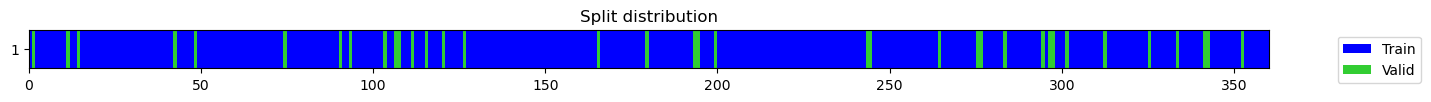

alpha: 1.00E+01  train: 0.99691  valid: 0.72222
[[52.  9. 23. 15.]
 [15. 72.  6.  6.]
 [ 7.  6. 80.  6.]
 [13.  7.  0. 79.]]
alpha: 1.00E+02  train: 0.86420  valid: 0.83333
[[60. 10. 23. 15.]
 [15. 81.  6.  6.]
 [ 8.  6. 87.  7.]
 [15.  8.  0. 85.]]


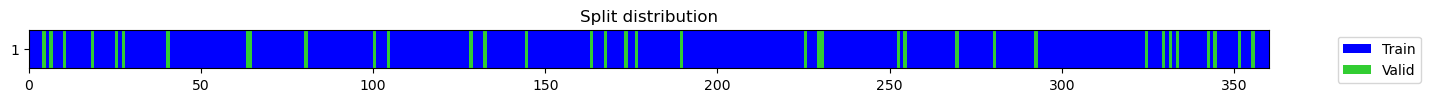

alpha: 1.00E+01  train: 0.99691  valid: 0.63889
[[66. 10. 26. 15.]
 [15. 88.  7.  7.]
 [ 9.  9. 92.  7.]
 [16.  9.  2. 90.]]
alpha: 1.00E+02  train: 0.87654  valid: 0.75000
[[74. 10. 27. 15.]
 [15. 95.  8.  8.]
 [11. 10. 98.  7.]
 [18.  9.  3. 96.]]


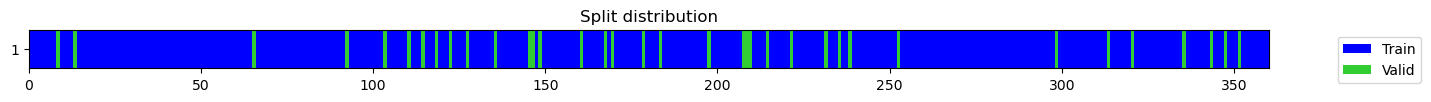

alpha: 1.00E+01  train: 0.99691  valid: 0.72222
[[ 80.  11.  28.  16.]
 [ 16. 102.   8.   9.]
 [ 11.  11. 105.   8.]
 [ 19.   9.   5. 102.]]
alpha: 1.00E+02  train: 0.86728  valid: 0.75000
[[ 86.  12.  29.  17.]
 [ 17. 108.   9.  10.]
 [ 11.  11. 113.   9.]
 [ 21.   9.   5. 109.]]


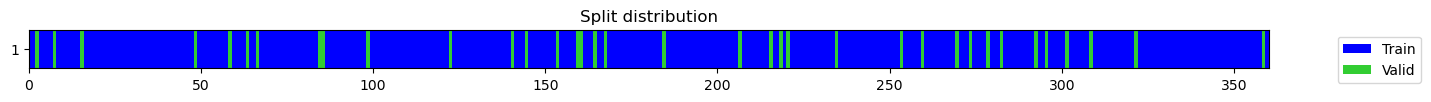

alpha: 1.00E+01  train: 0.99691  valid: 0.75000
[[ 93.  13.  30.  17.]
 [ 18. 116.   9.  10.]
 [ 12.  12. 119.  10.]
 [ 23.   9.   6. 115.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.72222
[[ 98.  14.  32.  18.]
 [ 19. 124.   9.  10.]
 [ 13.  13. 126.  10.]
 [ 25.   9.   7. 121.]]


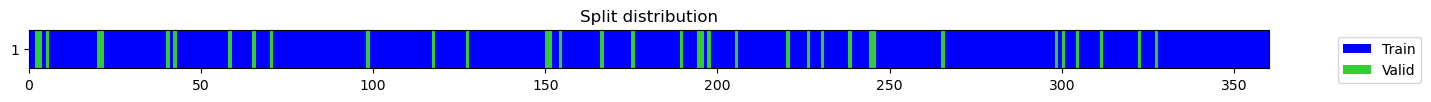

alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[103.  14.  34.  20.]
 [ 19. 132.  10.  10.]
 [ 14.  14. 132.  11.]
 [ 27.  10.   7. 127.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.72222
[[108.  14.  37.  21.]
 [ 19. 140.  11.  10.]
 [ 16.  14. 139.  11.]
 [ 29.  10.   8. 133.]]


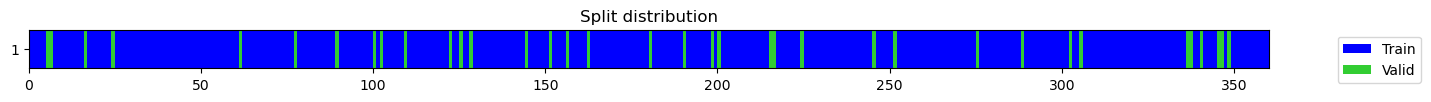

alpha: 1.00E+01  train: 0.99691  valid: 0.63889
[[114.  14.  39.  22.]
 [ 20. 145.  14.  10.]
 [ 16.  16. 145.  12.]
 [ 29.  12.   9. 139.]]
alpha: 1.00E+02  train: 0.87346  valid: 0.63889
[[118.  14.  42.  24.]
 [ 20. 151.  17.  10.]
 [ 16.  18. 151.  13.]
 [ 30.  13.   9. 146.]]


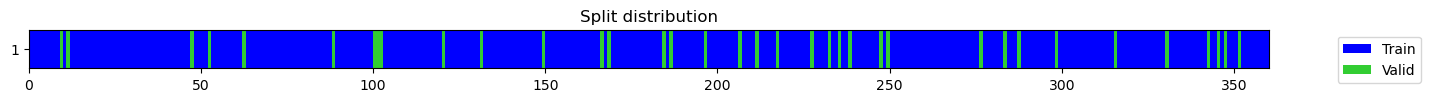

alpha: 1.00E+01  train: 0.99691  valid: 0.63889
[[122.  15.  44.  26.]
 [ 20. 159.  18.  10.]
 [ 16.  19. 157.  15.]
 [ 31.  14.  11. 151.]]
alpha: 1.00E+01  train: 1.00000  valid: 0.72222
[[127.  17.  46.  26.]
 [ 20. 166.  20.  10.]
 [ 16.  20. 165.  15.]
 [ 32.  16.  11. 157.]]


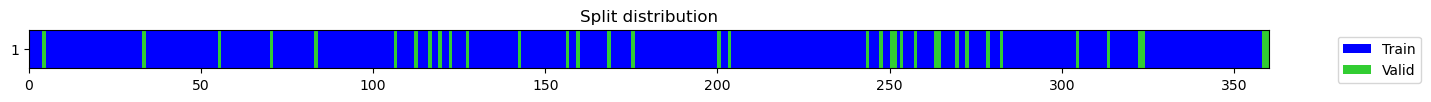

alpha: 1.00E+01  train: 0.99691  valid: 0.50000
[[133.  18.  47.  27.]
 [ 23. 170.  22.  10.]
 [ 18.  21. 170.  16.]
 [ 33.  19.  13. 160.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[141.  18.  47.  28.]
 [ 25. 176.  23.  10.]
 [ 18.  23. 176.  17.]
 [ 35.  21.  13. 165.]]


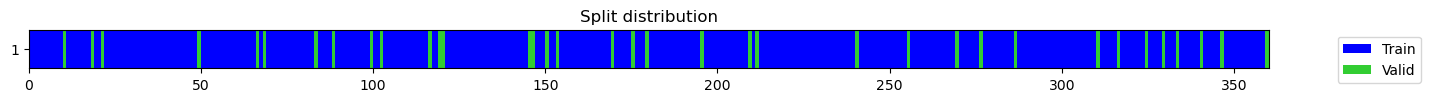

alpha: 1.00E+01  train: 0.99691  valid: 0.75000
[[148.  18.  49.  28.]
 [ 26. 183.  24.  10.]
 [ 19.  24. 182.  18.]
 [ 35.  22.  14. 172.]]
alpha: 1.00E+01  train: 1.00000  valid: 0.69444
[[152.  18.  53.  29.]
 [ 28. 189.  25.  10.]
 [ 21.  24. 189.  18.]
 [ 35.  23.  14. 180.]]


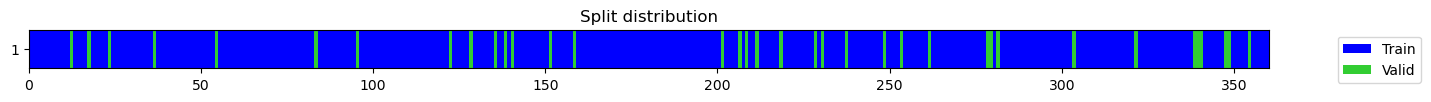

alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[157.  18.  54.  32.]
 [ 28. 195.  28.  10.]
 [ 21.  26. 196.  18.]
 [ 35.  23.  16. 187.]]
alpha: 1.00E+01  train: 1.00000  valid: 0.75000
[[163.  18.  55.  34.]
 [ 28. 201.  31.  10.]
 [ 21.  26. 204.  19.]
 [ 36.  23.  17. 194.]]


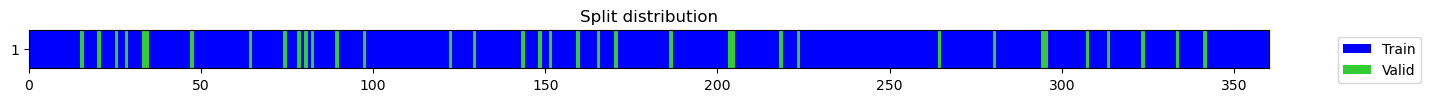

alpha: 1.00E+01  train: 1.00000  valid: 0.63889
[[168.  19.  57.  35.]
 [ 30. 207.  32.  10.]
 [ 22.  27. 209.  21.]
 [ 38.  23.  17. 201.]]
alpha: 1.00E+01  train: 0.99383  valid: 0.69444
[[173.  21.  58.  36.]
 [ 31. 213.  34.  10.]
 [ 23.  27. 215.  23.]
 [ 39.  23.  17. 209.]]


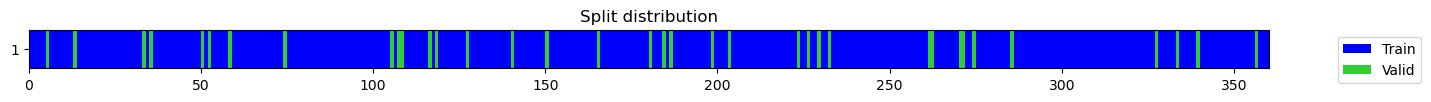

alpha: 1.00E+01  train: 0.99691  valid: 0.77778
[[179.  21.  60.  37.]
 [ 32. 220.  35.  10.]
 [ 23.  28. 223.  23.]
 [ 39.  24.  18. 216.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.66667
[[182.  23.  64.  37.]
 [ 32. 229.  35.  10.]
 [ 25.  29. 229.  23.]
 [ 40.  25.  19. 222.]]


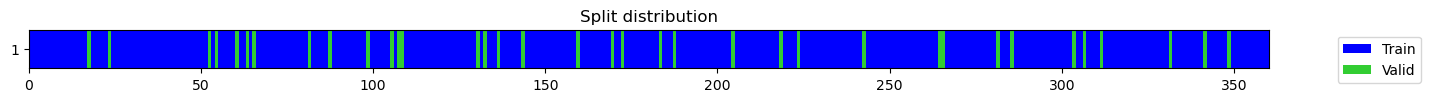

alpha: 1.00E+01  train: 0.99691  valid: 0.55556
[[187.  23.  66.  39.]
 [ 35. 232.  38.  10.]
 [ 25.  30. 236.  24.]
 [ 43.  25.  20. 227.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.69444
[[192.  23.  69.  40.]
 [ 36. 238.  40.  10.]
 [ 25.  30. 245.  24.]
 [ 47.  25.  20. 232.]]


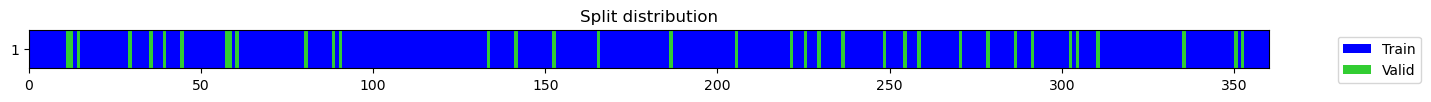

alpha: 1.00E+01  train: 1.00000  valid: 0.69444
[[197.  23.  70.  43.]
 [ 37. 245.  40.  11.]
 [ 26.  30. 253.  24.]
 [ 48.  25.  23. 237.]]
alpha: 1.00E+01  train: 0.99691  valid: 0.75000
[[203.  23.  70.  46.]
 [ 37. 253.  41.  11.]
 [ 27.  30. 261.  24.]
 [ 50.  25.  25. 242.]]


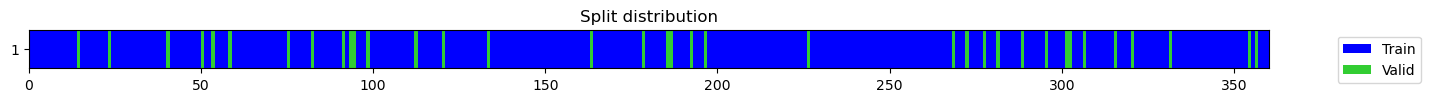

alpha: 1.00E+01  train: 0.99691  valid: 0.86111
[[212.  23.  70.  46.]
 [ 37. 260.  41.  13.]
 [ 27.  30. 270.  24.]
 [ 52.  25.  26. 248.]]
alpha: 1.00E+02  train: 0.85494  valid: 0.83333
[[221.  23.  70.  46.]
 [ 38. 267.  41.  14.]
 [ 27.  30. 279.  24.]
 [ 55.  25.  27. 253.]]


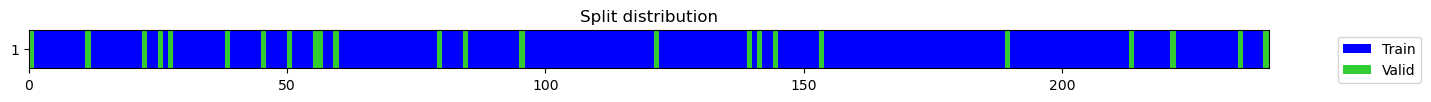

alpha: 1.00E+01  train: 0.99537  valid: 0.58333
[[2. 3. 1. 0.]
 [0. 4. 1. 1.]
 [1. 2. 3. 0.]
 [0. 1. 0. 5.]]
alpha: 1.00E+02  train: 0.92593  valid: 0.62500
[[ 5.  5.  2.  0.]
 [ 0.  8.  3.  1.]
 [ 3.  2.  6.  1.]
 [ 0.  1.  1. 10.]]


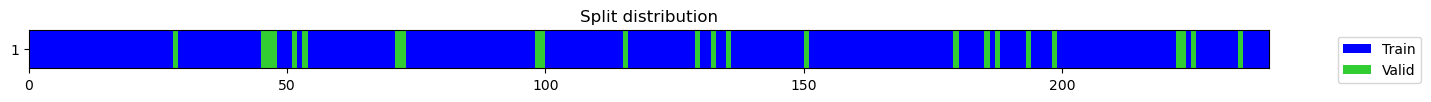

alpha: 1.00E+01  train: 1.00000  valid: 0.79167
[[10.  6.  2.  0.]
 [ 1. 13.  3.  1.]
 [ 4.  2. 11.  1.]
 [ 1.  1.  2. 14.]]
alpha: 1.00E+02  train: 0.92130  valid: 0.70833
[[15.  7.  2.  0.]
 [ 2. 18.  3.  1.]
 [ 6.  2. 14.  2.]
 [ 2.  1.  3. 18.]]


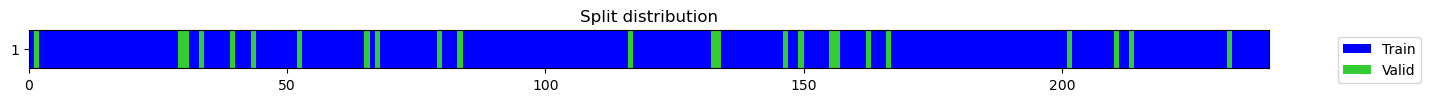

alpha: 1.00E+01  train: 0.99537  valid: 0.83333
[[21.  7.  2.  0.]
 [ 3. 23.  3.  1.]
 [ 6.  2. 20.  2.]
 [ 3.  2.  4. 21.]]
alpha: 1.00E+02  train: 0.91204  valid: 0.83333
[[27.  7.  2.  0.]
 [ 4. 28.  3.  1.]
 [ 6.  2. 26.  2.]
 [ 3.  3.  6. 24.]]


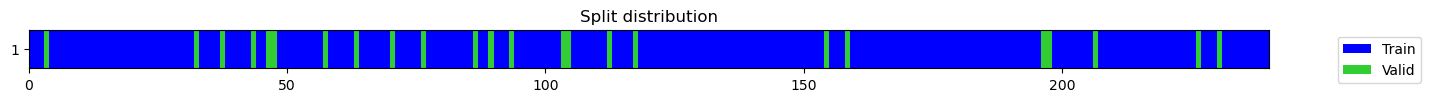

alpha: 1.00E+01  train: 0.99537  valid: 0.75000
[[30.  9.  3.  0.]
 [ 4. 34.  3.  1.]
 [ 6.  4. 30.  2.]
 [ 4.  3.  6. 29.]]
alpha: 1.00E+02  train: 0.93056  valid: 0.79167
[[33. 11.  4.  0.]
 [ 4. 40.  3.  1.]
 [ 7.  4. 35.  2.]
 [ 5.  3.  6. 34.]]


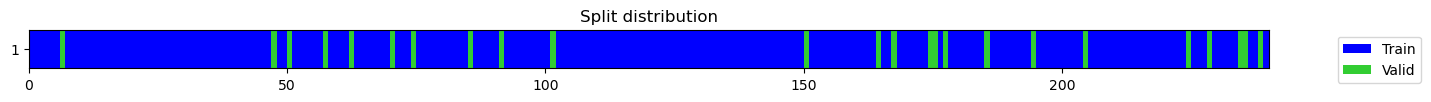

alpha: 1.00E+01  train: 0.99537  valid: 0.70833
[[36. 12.  6.  0.]
 [ 4. 44.  5.  1.]
 [ 7.  6. 39.  2.]
 [ 5.  3.  6. 40.]]
alpha: 1.00E+02  train: 0.90278  valid: 0.79167
[[39. 12.  9.  0.]
 [ 4. 49.  6.  1.]
 [ 8.  6. 44.  2.]
 [ 5.  3.  6. 46.]]


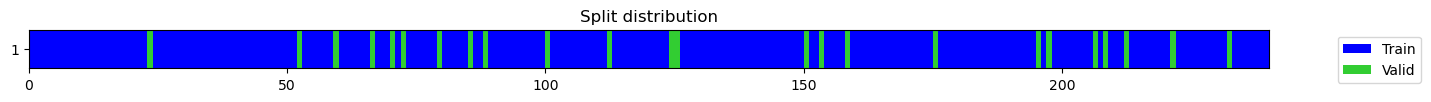

alpha: 1.00E+01  train: 1.00000  valid: 0.66667
[[43. 13. 10.  0.]
 [ 4. 52.  8.  2.]
 [10.  6. 48.  2.]
 [ 5.  3.  7. 51.]]
alpha: 1.00E+02  train: 0.91667  valid: 0.66667
[[48. 13. 10.  1.]
 [ 5. 54. 10.  3.]
 [12.  6. 52.  2.]
 [ 6.  3.  7. 56.]]


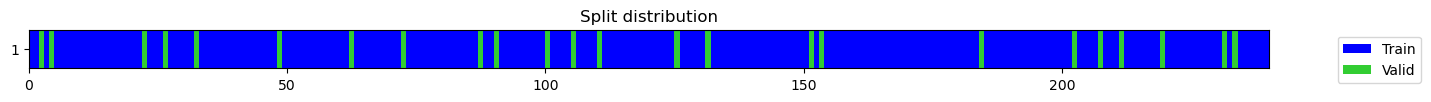

alpha: 1.00E+01  train: 0.99537  valid: 0.83333
[[53. 13. 10.  2.]
 [ 5. 60. 10.  3.]
 [12.  6. 55.  5.]
 [ 6.  3.  7. 62.]]
alpha: 1.00E+02  train: 0.92593  valid: 0.83333
[[59. 13. 10.  2.]
 [ 5. 64. 11.  4.]
 [12.  6. 59.  7.]
 [ 6.  3.  7. 68.]]


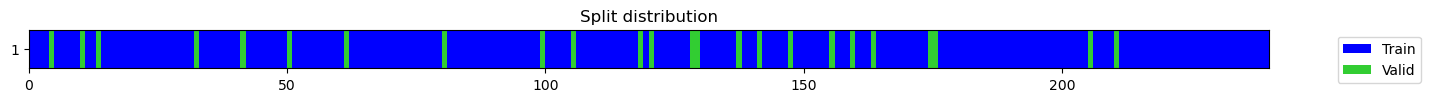

alpha: 1.00E+01  train: 0.99537  valid: 0.83333
[[65. 13. 10.  2.]
 [ 5. 69. 12.  4.]
 [13.  6. 63.  8.]
 [ 7.  3.  7. 73.]]
alpha: 1.00E+02  train: 0.92130  valid: 0.62500
[[71. 13. 10.  2.]
 [ 5. 73. 14.  4.]
 [15.  6. 66.  9.]
 [ 9.  4.  8. 75.]]


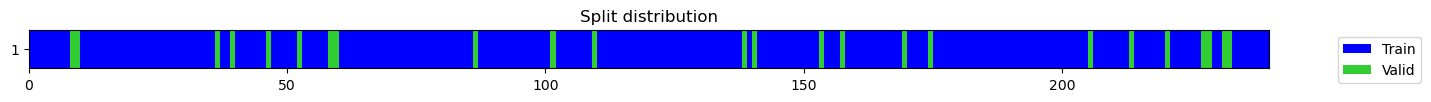

alpha: 1.00E+01  train: 0.99537  valid: 0.70833
[[74. 14. 12.  2.]
 [ 5. 77. 15.  5.]
 [16.  7. 70.  9.]
 [ 9.  4.  8. 81.]]
alpha: 1.00E+02  train: 0.93056  valid: 0.79167
[[78. 15. 13.  2.]
 [ 5. 82. 15.  6.]
 [17.  7. 75.  9.]
 [ 9.  4.  9. 86.]]


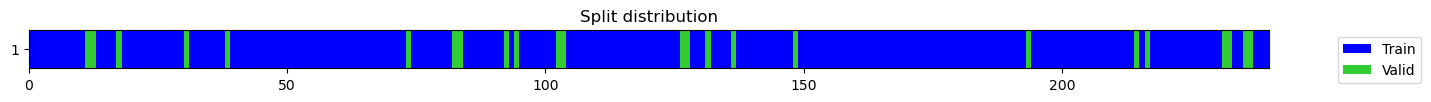

alpha: 1.00E+01  train: 0.99537  valid: 0.79167
[[81. 16. 14.  3.]
 [ 5. 88. 15.  6.]
 [17.  7. 80. 10.]
 [ 9.  5.  9. 91.]]
alpha: 1.00E+02  train: 0.92130  valid: 1.00000
[[87. 16. 14.  3.]
 [ 5. 94. 15.  6.]
 [17.  7. 86. 10.]
 [ 9.  5.  9. 97.]]


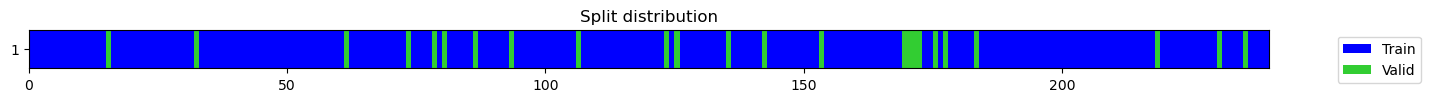

alpha: 1.00E+01  train: 0.99537  valid: 0.91667
[[ 93.  16.  14.   3.]
 [  6.  99.  15.   6.]
 [ 17.   7.  91.  11.]
 [  9.   5.   9. 103.]]
alpha: 1.00E+02  train: 0.91667  valid: 0.79167
[[ 97.  16.  15.   4.]
 [  7. 103.  16.   6.]
 [ 17.   7.  96.  12.]
 [  9.   5.   9. 109.]]


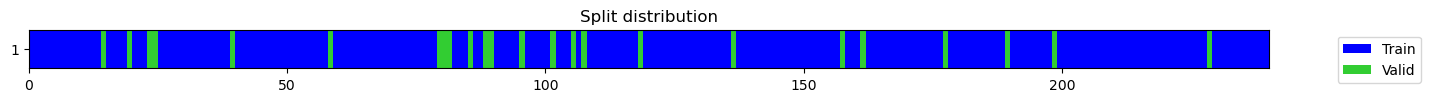

alpha: 1.00E+01  train: 1.00000  valid: 0.66667
[[101.  18.  15.   4.]
 [  9. 106.  17.   6.]
 [ 18.   7. 100.  13.]
 [ 10.   5.   9. 114.]]
alpha: 1.00E+02  train: 0.93056  valid: 0.70833
[[106.  19.  15.   4.]
 [ 11. 109.  18.   6.]
 [ 19.   7. 104.  14.]
 [ 11.   5.   9. 119.]]


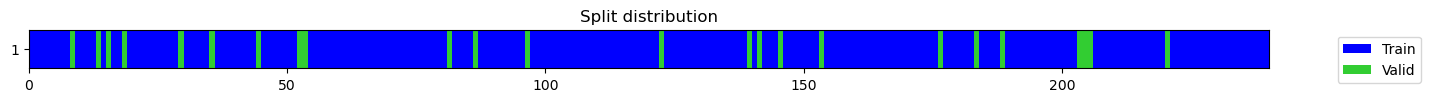

alpha: 1.00E+01  train: 0.99074  valid: 0.75000
[[109.  20.  17.   4.]
 [ 12. 113.  18.   7.]
 [ 19.   7. 109.  15.]
 [ 11.   5.   9. 125.]]
alpha: 1.00E+02  train: 0.92130  valid: 0.83333
[[115.  20.  17.   4.]
 [ 12. 117.  19.   8.]
 [ 19.   7. 114.  16.]
 [ 11.   5.  10. 130.]]


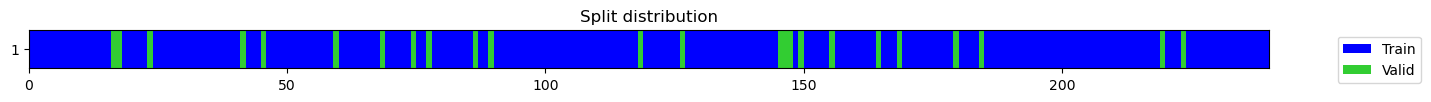

alpha: 1.00E+01  train: 1.00000  valid: 0.83333
[[120.  20.  18.   4.]
 [ 13. 122.  19.   8.]
 [ 19.   7. 119.  17.]
 [ 11.   5.  11. 135.]]
alpha: 1.00E+02  train: 0.92130  valid: 0.79167
[[124.  20.  18.   6.]
 [ 14. 127.  19.   8.]
 [ 19.   7. 124.  18.]
 [ 11.   6.  11. 140.]]


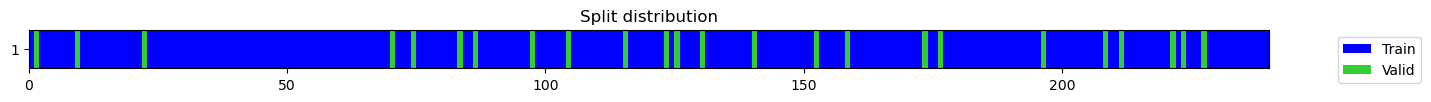

alpha: 1.00E+01  train: 0.99537  valid: 0.79167
[[129.  20.  19.   6.]
 [ 14. 132.  19.   9.]
 [ 20.   7. 127.  20.]
 [ 11.   6.  11. 146.]]
alpha: 1.00E+02  train: 0.93056  valid: 0.83333
[[134.  20.  20.   6.]
 [ 14. 137.  20.   9.]
 [ 20.   7. 131.  22.]
 [ 11.   6.  11. 152.]]


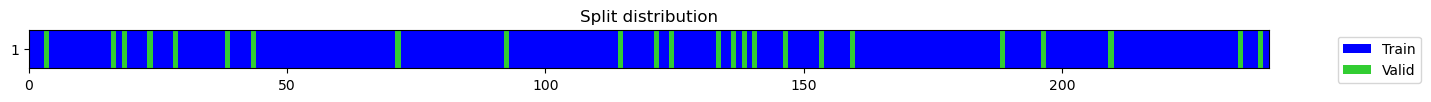

alpha: 1.00E+01  train: 0.99537  valid: 0.66667
[[139.  20.  21.   6.]
 [ 14. 139.  24.   9.]
 [ 21.   8. 134.  23.]
 [ 11.   6.  11. 158.]]
alpha: 1.00E+02  train: 0.93981  valid: 0.66667
[[144.  20.  22.   6.]
 [ 14. 141.  28.   9.]
 [ 22.   8. 138.  24.]
 [ 11.   7.  11. 163.]]


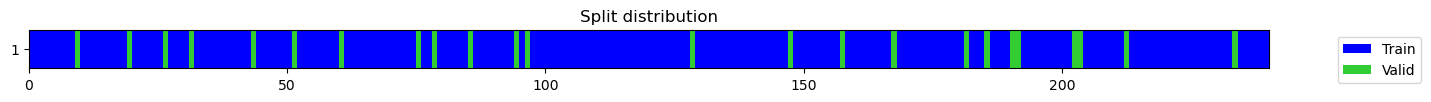

alpha: 1.00E+02  train: 0.93056  valid: 0.87500
[[149.  20.  22.   7.]
 [ 14. 146.  29.   9.]
 [ 23.   8. 143.  24.]
 [ 11.   7.  11. 169.]]
alpha: 1.00E+02  train: 0.91204  valid: 0.91667
[[155.  20.  22.   7.]
 [ 14. 151.  29.  10.]
 [ 24.   8. 148.  24.]
 [ 11.   7.  11. 175.]]


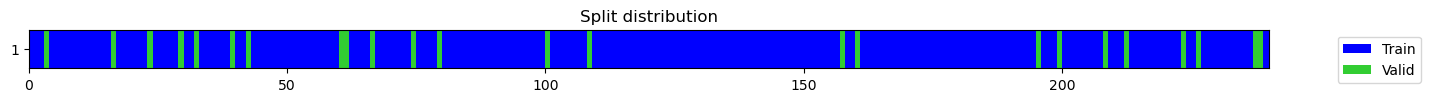

alpha: 1.00E+01  train: 0.99537  valid: 0.79167
[[159.  21.  23.   7.]
 [ 14. 157.  29.  10.]
 [ 25.  10. 151.  24.]
 [ 11.   7.  11. 181.]]
alpha: 1.00E+02  train: 0.92593  valid: 0.83333
[[164.  22.  23.   7.]
 [ 14. 162.  30.  10.]
 [ 26.  11. 155.  24.]
 [ 11.   7.  11. 187.]]


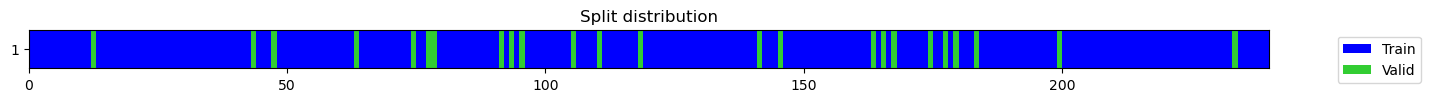

alpha: 1.00E+01  train: 0.99537  valid: 0.79167
[[168.  23.  24.   7.]
 [ 15. 167.  30.  10.]
 [ 26.  12. 160.  24.]
 [ 11.   7.  12. 192.]]
alpha: 1.00E+01  train: 1.00000  valid: 0.79167
[[171.  24.  26.   7.]
 [ 15. 172.  30.  11.]
 [ 26.  12. 166.  24.]
 [ 11.   7.  13. 197.]]


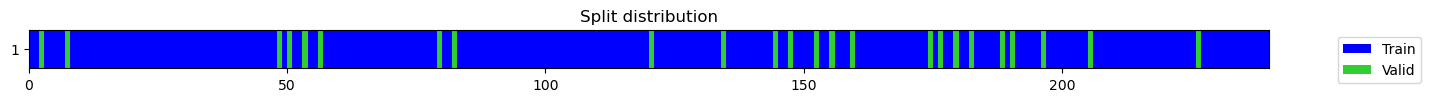

alpha: 1.00E+01  train: 0.99537  valid: 0.70833
[[177.  24.  26.   7.]
 [ 16. 175.  31.  12.]
 [ 27.  12. 170.  25.]
 [ 11.   8.  14. 201.]]
alpha: 1.00E+01  train: 1.00000  valid: 0.75000
[[183.  24.  26.   7.]
 [ 17. 178.  32.  13.]
 [ 28.  12. 174.  26.]
 [ 11.   8.  15. 206.]]


In [20]:
srate = 2000
new_srate = 200
ele_original = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)
# 去除第一秒的数据,且重采样到200hz

mask = np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))-2
data = []
total_acc = []
for time_in_sec in [2, 3, 4]:
    sec = time_in_sec # time step length
    if 9%time_in_sec ==0:
        ele = np.reshape(
            ele_original, (20000,15,4,2,14), order = 'F').\
                transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]
    else:
        ele = np.reshape(
            ele_original, (20000,15,4,2,14), order = 'F').\
                transpose([2,1,3,0,4])[:,:,:,srate:-srate:srate//new_srate,:]
        
    ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
    y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))
    
    # z-score
    ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                    /ear_ele.std(axis = 2)[...,np.newaxis]




    # time frequency analysis for ear-EEG
    temp_ear_ele = []
    for flame in ear_ele:
        _,_,temp = time_frequency_analysis(
            flame.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 0.75 * time_in_sec)
  
        temp_ear_ele.append(temp)
    
    # if use mask
    ear_ele_NOmask = np.asarray(temp_ear_ele)
    ear_ele_masked = np.asarray(temp_ear_ele)[:,mask,:]
    # print(ear_ele.shape)
    temp_acc, cf_matrix = cross_validation(ear_ele_NOmask, ear_ele_masked,
                                           y, cv_number = 20, test_size = 0.1)
    pd.concat([pd.read_csv(r'result/ROCKET_ACC_with_mask.csv', header = 0),
               pd.DataFrame(np.asarray(temp_acc).reshape(-1, 2), 
                            columns=[f'{time_in_sec}s_NOmask', f'{time_in_sec}s_masked'])], 
          axis = 1).to_csv(r'result/ROCKET_ACC_with_mask.csv', index= None)
    
#     pd.DataFrame(cf_matrix).to_csv(
#         r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_cfmatrix_01_13.csv', 
#         mode = 'a', index = None, header = None)
    total_acc.append(temp_acc)

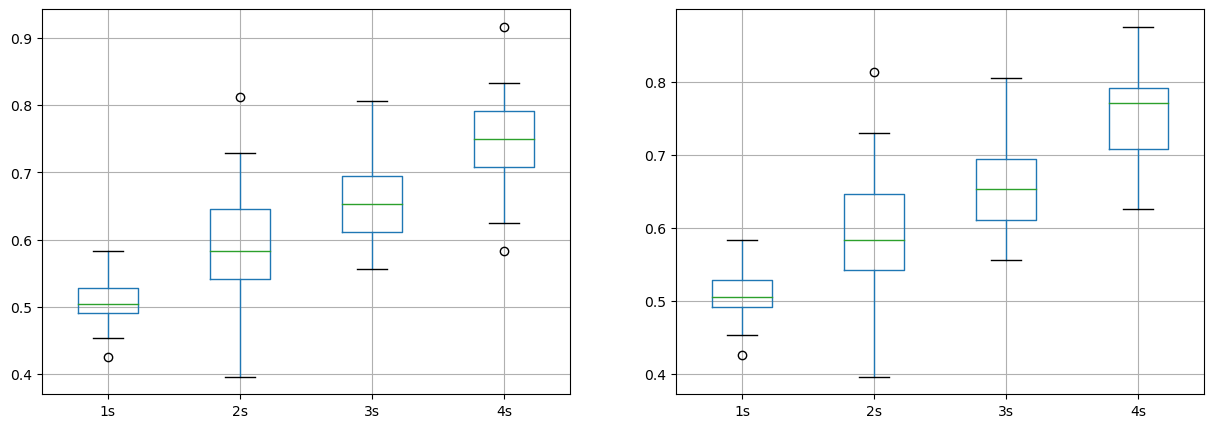

In [38]:
plt.figure(figsize = (15, 5))
plt.clf()
plt.subplot(1,2,1)
pd.read_csv(r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_ACC_01_13.csv', 
            index_col = 0, header = 0).boxplot()
plt.subplot(1,2,2)
pd.read_csv(r'C:\MY\matlab\SSVEP\seesion2\result\ROCKET_ACC_01_13_2.csv', 
            index_col = None, header = 0).boxplot()
plt.show()

In [17]:
np.asarray(total_acc).mean()

0.7562500000000001

In [28]:
pd.DataFrame(total_acc[0], columns = ['4s']).to_csv(r'result\ROCKET_ACC_01_13_2.csv', index = None)

In [48]:
pd.DataFrame(cf_matrix).to_csv(r'result\ROCKET_cfmatrix_01_13_2.csv', 
                               mode = 'a', index = None, header = None)

In [47]:
pd.DataFrame(total_acc[0]).to_csv(r'result\ROCKET_ACC_01_13_2.csv', 
                               mode = 'a', index = None, header = None)

In [13]:
    pd.concat([pd.read_csv(r'result/ROCKET_ACC_with_mask.csv', header = 0),
               pd.DataFrame(np.asarray(temp_acc).reshape(-1, 2), 
                            columns=[f'{time_in_sec}s_NOmask', f'{time_in_sec}s_masked'])], 
          axis = 1).to_csv(r'result/ROCKET_ACC_with_mask.csv', index= None)

In [11]:
np.asarray(temp_acc).reshape(-1, 2).T.mean(axis = 1)

array([0.51990741, 0.4962963 ])

In [15]:
stats.ttest_rel(np.asarray(temp_acc).reshape(-1, 2).T[0], 
                np.asarray(temp_acc).reshape(-1, 2).T[1])

Ttest_relResult(statistic=2.783368292197035, pvalue=0.011844808651100897)

In [18]:
 pd.concat([pd.read_csv(r'result/ROCKET_ACC_with_mask.csv', header = 0),
               pd.DataFrame(np.asarray(temp_acc).reshape(-1, 2), 
                            columns=[f'{time_in_sec}s_NOmask', f'{time_in_sec}s_masked'])], 
          axis = 1)

,number,1s_NOmask,1s_masked,1s_NOmask,1s_masked
0,1,0.555556,0.490741,0.555556,0.490741
1,2,0.518519,0.527778,0.518519,0.527778
2,3,0.518519,0.490741,0.518519,0.490741
3,4,0.583333,0.555556,0.583333,0.555556
4,5,0.527778,0.453704,0.527778,0.453704
5,6,0.518519,0.509259,0.518519,0.509259
6,7,0.509259,0.490741,0.509259,0.490741
7,8,0.638889,0.574074,0.638889,0.574074
8,9,0.509259,0.490741,0.509259,0.490741
9,10,0.509259,0.518519,0.509259,0.518519


In [19]:
np.asarray(temp_acc).reshape(-1, 2)

array([[0.55555556, 0.49074074],
       [0.51851852, 0.52777778],
       [0.51851852, 0.49074074],
       [0.58333333, 0.55555556],
       [0.52777778, 0.4537037 ],
       [0.51851852, 0.50925926],
       [0.50925926, 0.49074074],
       [0.63888889, 0.57407407],
       [0.50925926, 0.49074074],
       [0.50925926, 0.51851852],
       [0.53703704, 0.53703704],
       [0.48148148, 0.50925926],
       [0.48148148, 0.48148148],
       [0.50925926, 0.51851852],
       [0.56481481, 0.4537037 ],
       [0.47222222, 0.49074074],
       [0.5       , 0.42592593],
       [0.5       , 0.44444444],
       [0.49074074, 0.49074074],
       [0.47222222, 0.47222222]])

In [21]:
2+3

5

In [22]:
np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))

array([ 5,  7,  9, 10, 11, 14, 15, 18, 20, 21, 22, 25, 27, 28, 30, 33, 35,
       36, 40, 42, 44, 45, 49, 50, 54, 55, 56])